In [1]:
import qcodes as qc
import numpy as np
import yaml
from qdev_wrappers.station_configurator import StationConfigurator
from qdev_wrappers.customised_instruments.awg_interface import SimulatedAWGInterface
from qdev_wrappers.customised_instruments.parametric_sequencer import ParametricSequencer
from readout_template_element import create_readout_template_element


from qcodes.instrument_drivers.Abaco.AbacoDac import AbacoDAC

/anaconda3/envs/qcodes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/Lillian/qdev-wrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '
/Users/Lillian/qdev-wrappers/qdev_wrappers/station_configurator.py:21: UserWarning: ruamel yaml not found station configurator is falling back to pyyaml. It's highly recommended to install ruamel.yaml. This fixes issues with scientific notation and duplicate instruments in the YAML file
  warnings.warn("ruamel yaml not found station configurator is falling back to pyyaml. "


uploading


/anaconda3/envs/qcodes/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


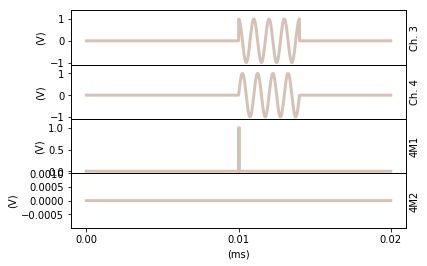

In [2]:
with open('./pulse_building_defaults.yaml') as f:
   initial_sequence_settings = yaml.safe_load(f) 

awg_interface = SimulatedAWGInterface()

initial_template_element = create_readout_template_element()

ps = ParametricSequencer('ps', template_element=initial_template_element,
                                inner_setpoints=('dummy_param', [1]),
                                context=initial_sequence_settings['context'],
                                labels=initial_sequence_settings['labels'],
                                units=initial_sequence_settings['units'],
                                awg=awg_interface)

In [3]:
ps.sequence

<SequenceChannel: ps_sequence_parameters of ParametricSequencer: ps>

In [4]:
ps._sequence_object

In [5]:
import copy
fs1 = ps._sequence_object.forge(SR=ps.awg.get_SR(), context=ps._sequence_context)
fs1[0]['data'][1] = fs1[0]['data']['4M1']
del(fs1[0]['data']['4M1'])
fs1[0]['data'][2] = fs1[0]['data']['4M2']
del(fs1[0]['data']['4M2'])
fs1[0]['sequencing']['nrep'] = 1
seq = [copy.deepcopy(d) for d in fs1]
fs1[0]['sequencing']['nrep'] = 3
seq.append(copy.deepcopy(fs1[0]))

seq
fs1[0]['sequencing']['nrep'] = 1
fs1

[{'data': {3: array([0., 0., 0., ..., 0., 0., 0.]),
   4: array([0., 0., 0., ..., 0., 0., 0.]),
   1: array([0., 0., 0., ..., 0., 0., 0.]),
   2: array([0., 0., 0., ..., 0., 0., 0.])},
  'sequencing': {'nrep': 1, 'goto_state': 1}}]

In [20]:
fs1[0]

[{'data': {3: array([0., 0., 0., ..., 0., 0., 0.]),
   4: array([0., 0., 0., ..., 0., 0., 0.]),
   1: array([0., 0., 0., ..., 0., 0., 0.]),
   2: array([0., 0., 0., ..., 0., 0., 0.])},
  'sequencing': {'nrep': 1, 'goto_state': 1}}]

In [19]:
V_PP_DC = 1.7
V_PP_AC = 1

max_16b2c = 32767 #maximum value in 16 bit twos complement format

max_Vpp = V_PP_DC # (or V_PP_AC)

Vpp = 1.5

def twos_complement_val(array):
    """Takes array from sequence data, with all array values between -1 and 1.
        
    Returns an array with the values numbers converted to twos-complement data,
    corresponding to voltages to be output. Voltages are converted based on the 
    parameter Vpp, such that 1 in the element data corresponds to the maximum 
    voltage, and -1 to the minimum voltage."""
    
    #if not -Vpp/2 <= voltage <= Vpp/2:
    #    raise TypeError(f'Allowed voltages are {-Vpp/2}V to {Vpp/2}V. ' 
    #                    f'Tried setting voltage to {voltage}V.')
        # ToDo: add option for defining offset? Or is offset defined in the forged sequence?
        # ToDo: where does the check go on the tetronix that tells you the voltage is out of bounds?
    
    amplitude_scaling = (Vpp/max_Vpp)
    
    new_array = (array * max_16b2c * amplitude_scaling).astype(int) 
        # ToDo: they still need to be made into integers
        # ToDo: add peak-to-peak voltage as a parameter of the instrument
    
    return new_array


In [9]:
import io
#header, data, foa = AbacoDAC._makeTextDataFile(seq, 1)
header, data = AbacoDAC._makeTextDataFile(fs1, 2)

In [10]:
test = io.StringIO()

In [11]:
print('blah', file=test)

In [12]:
test.readlines()

[]

In [13]:
test.write('blah')

4

In [14]:
test.readline()

''

In [15]:
print(test.getvalue())

blah
blah


In [16]:
data['_0']

In [17]:
file = io.StringIO()

file.write(header.getvalue())
file.write(data['_0'].getvalue())

TypeError: string argument expected, got 'bytes'

In [ ]:
import shutil

dformat=1
FILENAME = 'does_this_work_{}.{}'

if dformat == 1:
    file_access = 'w'
else:
    file_access = 'wb'

# write files to disk
for i in range(1):
    with open(FILENAME.format(i, 'txt'), file_access) as fd:
        file.seek(0)
        shutil.copyfileobj(file, fd)

In [ ]:
print(header.getvalue())

In [18]:
AbacoDAC._create_files(header, data, 2)

_0
_1


In [ ]:
data

In [ ]:
for i in data:
    print(data[i])

In [ ]:
    def forged_seq_array_to_16b2c(self, array):
        amplitude_scaling = self.Vpp/self.max_Vpp
        # ToDo: Vpp and max_Vpp need to be added as parameters
        return np.fix(array * self.max_16b2c * amplitude_scaling)